# Laboratorio 2

In [1061]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d
from skimage import io, color
from skimage.filters import prewitt_h, prewitt_v
import matplotlib.patches as patches
from skimage.transform import resize
import math

In [1062]:
def preprocess_image(image):
    if np.max(image) <= 1.0:
        image = (image * 255).astype(np.uint8)
    return image

In [1063]:
def show_image(image):
    image = preprocess_image(image)
    plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    plt.show()

## Ejercicio 1

In [1064]:
def convert_gray_scale(image):
    """Convert image to gray scale."""
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [1065]:
def rescale_image(image, k, n_width=128, n_height=64):
    """Rescale image by factor k."""
    new_height = n_height
    new_width = n_width
    new_shape = (int(new_width * k), int(new_height * k))
    return resize(image, new_shape)

In [1066]:
def read_and_preprocess_image(image_path, k=1, n_width=128, n_height=64):
    """Read image from file and preprocess it."""
    image = cv2.imread(image_path)
    image = convert_gray_scale(image)
    image = rescale_image(image, k, n_width, n_height)
    return image

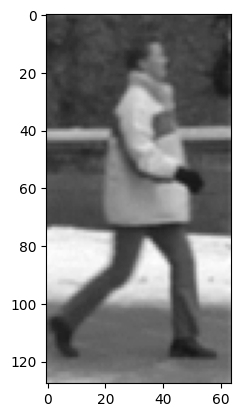

In [1067]:
image = read_and_preprocess_image('images/person.png')
show_image(image)

## Ejercicio 2

In [1068]:
def calcular_gradiente(imagen):
    imagen = preprocess_image(imagen)
    # Definir los filtros de Prewitt para calcular las correlaciones Gx y Gy
    filtro_prewitt_y = np.array([[-1, 0, 1],
                                  [-1, 0, 1],
                                  [-1, 0, 1]])
    filtro_prewitt_x = np.array([[-1, -1, -1],
                                  [0, 0, 0],
                                  [1, 1, 1]])

    # Realizar convolución de la imagen con los filtros de Prewitt
    gradiente_x = convolve2d(imagen, filtro_prewitt_x, mode='same', boundary='symm')
    gradiente_y = convolve2d(imagen, filtro_prewitt_y, mode='same', boundary='symm')

    # Calcular la magnitud del gradiente
    magnitud_gradiente = np.sqrt(gradiente_x**2 + gradiente_y**2)

    # Calcular el ángulo del gradiente en radianes
    angulo_gradiente = np.arctan2(gradiente_y, gradiente_x)

    # Convertir el ángulo a grados y asegurar que esté en el rango 0 <= θ < 180
    angulo_gradiente_grados = np.degrees(angulo_gradiente) % 180

    return magnitud_gradiente, angulo_gradiente_grados


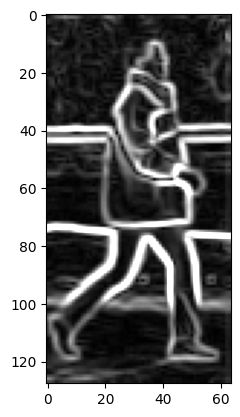

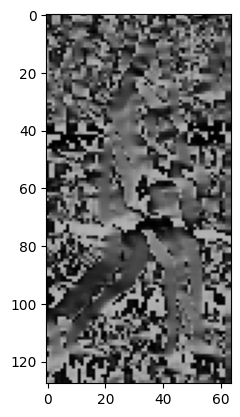

In [1069]:
gradient_magnitude, gradient_angle = calcular_gradiente(image)
show_image(gradient_magnitude)
show_image(gradient_angle)

## Ejercicio 3

In [1070]:
def build_block_stack(magnitud_gradiente, angulo_gradiente, block_size=8, stride=None):
    if stride is None:
        stride = block_size // 2
    # Calcular M y N según las fórmulas dadas
    M = magnitud_gradiente.shape[0] // (stride)
    N = magnitud_gradiente.shape[1] // (stride)

    # Inicializar los arrays para el stack de bloques de magnitud y ángulo del gradiente
    block_magnitude = np.zeros((M * N, block_size, block_size))
    block_angle = np.zeros((M * N, block_size, block_size))

    # Rellenar los arrays con los bloques de magnitud y ángulo del gradiente
    block_index = 0
    for y in range(M):
        for x in range(N):
            # Determinar la posición del bloque
            start_y = y * stride
            start_x = x * stride
            end_y = start_y + block_size
            end_x = start_x + block_size

            # Extraer los bloques de magnitud y ángulo y almacenarlos
            block_magnitude[block_index] = magnitud_gradiente[start_y:end_y, start_x:end_x]
            block_angle[block_index] = angulo_gradiente[start_y:end_y, start_x:end_x]

            block_index += 1

    return block_magnitude, block_angle


In [1071]:
blocks_magnitude, blocks_angle = build_block_stack(gradient_magnitude, gradient_angle, stride=8)
print(blocks_magnitude.shape)

(128, 8, 8)


## Ejercicio 4

In [1072]:
def visual_histogram(histogram):
    fig, ax = plt.subplots()
    ax.bar(range(len(histogram)), histogram, color='b')
    plt.show()

In [1073]:
def normalize_histogram(histogram, epsilon=1e-10):
    histogram = histogram / np.sqrt(np.linalg.norm(histogram)**2 + epsilon)
    return histogram


In [1074]:
def construir_histograma_de_gradientes(block_magnitude, block_angle, num_bins=9):
    # Inicializar el array para el histograma de gradientes
    H = np.zeros((block_magnitude.shape[0], num_bins))
    delta_angulo = 180 / num_bins

    # Calcular los centros de cada bin
    centros_bins = np.array([delta_angulo / 2 + i * delta_angulo for i in range(num_bins)])
    for block_index in range(block_magnitude.shape[0]):
        magnitudes = block_magnitude[block_index]
        angulos = block_angle[block_index]

        histograma = np.zeros(num_bins)
        for i in range(magnitudes.shape[0]):
            for k in range(magnitudes.shape[1]):
                mu = magnitudes[i, k]
                theta = angulos[i, k] % 180
                j = int(theta / delta_angulo)
                
                distancia_centro = abs(theta - (j * delta_angulo + delta_angulo / 2))
                
                # Calcula la contribución a los bins vecinos
                contribucion_principal = mu * (1 - (distancia_centro / delta_angulo))
                contribucion_vecino = mu - contribucion_principal

                # Asigna la contribución a los bins
                histograma[j] += contribucion_principal
                if theta > (j * delta_angulo + delta_angulo / 2):
                    # Si theta está más cerca del bin siguiente
                    histograma[(j + 1) % num_bins] += contribucion_vecino
                else:
                    # Si theta está más cerca del bin anterior
                    histograma[j - 1] += contribucion_vecino
                    
        H[block_index] = normalize_histogram(histograma)
    return H

(128, 9)


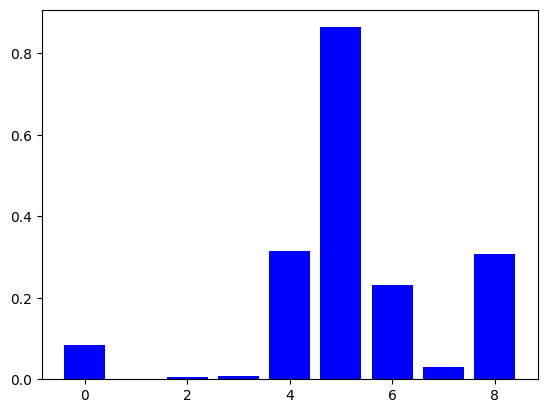

In [1075]:
histograms = construir_histograma_de_gradientes(blocks_magnitude, blocks_angle)
print(histograms.shape)
visual_histogram(histograms[102])

## Ejercicio 5

In [1076]:
def visualize_hog(H, image_shape, cell_size=8):
    delta_angulo = 180 / H.shape[1]
    blocks = []
    M = image_shape[0] // cell_size
    N = image_shape[1] // cell_size 
    max = np.max(H)
    min = np.min(H)
    for histogram in H:
        center = (cell_size // 2, cell_size // 2)
        block = np.zeros((cell_size, cell_size))
        for i in range(H.shape[1]):
            magnitude = histogram[i]
            magnitude = (magnitude - min) / (max - min)
            angle = (i * delta_angulo) % 180
            x1 = center[0] + magnitude * np.cos(np.radians(angle)) * cell_size // 2
            y1 = center[1] + magnitude * np.sin(np.radians(angle)) * cell_size // 2
            x2 = center[0] - magnitude * np.cos(np.radians(angle)) * cell_size // 2
            y2 = center[1] - magnitude * np.sin(np.radians(angle)) * cell_size // 2
            cv2.line(block, (int(x1), int(y1)), (int(x2), int(y2)), int(magnitude * 255))
        blocks.append(block)
    
    blocks = np.array(blocks)
    blocks = blocks.reshape((M, N, cell_size, cell_size))
    image = np.block([[blocks[i, j] for j in range(N)] for i in range(M)])
    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    return normalized_image


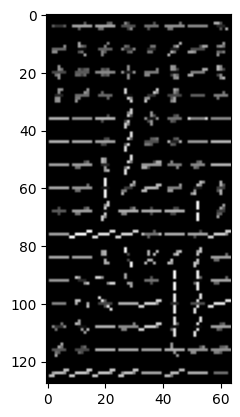

In [1077]:
xd = visualize_hog(histograms, image.shape)
show_image(xd)

## Ejercicio 6

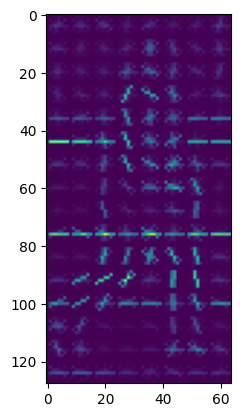

In [1078]:
from skimage.feature import hog
fd, hogI = hog(image.copy(), orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

plt.figure()
plt.imshow(hogI)
plt.show()

## Ejercicio 7

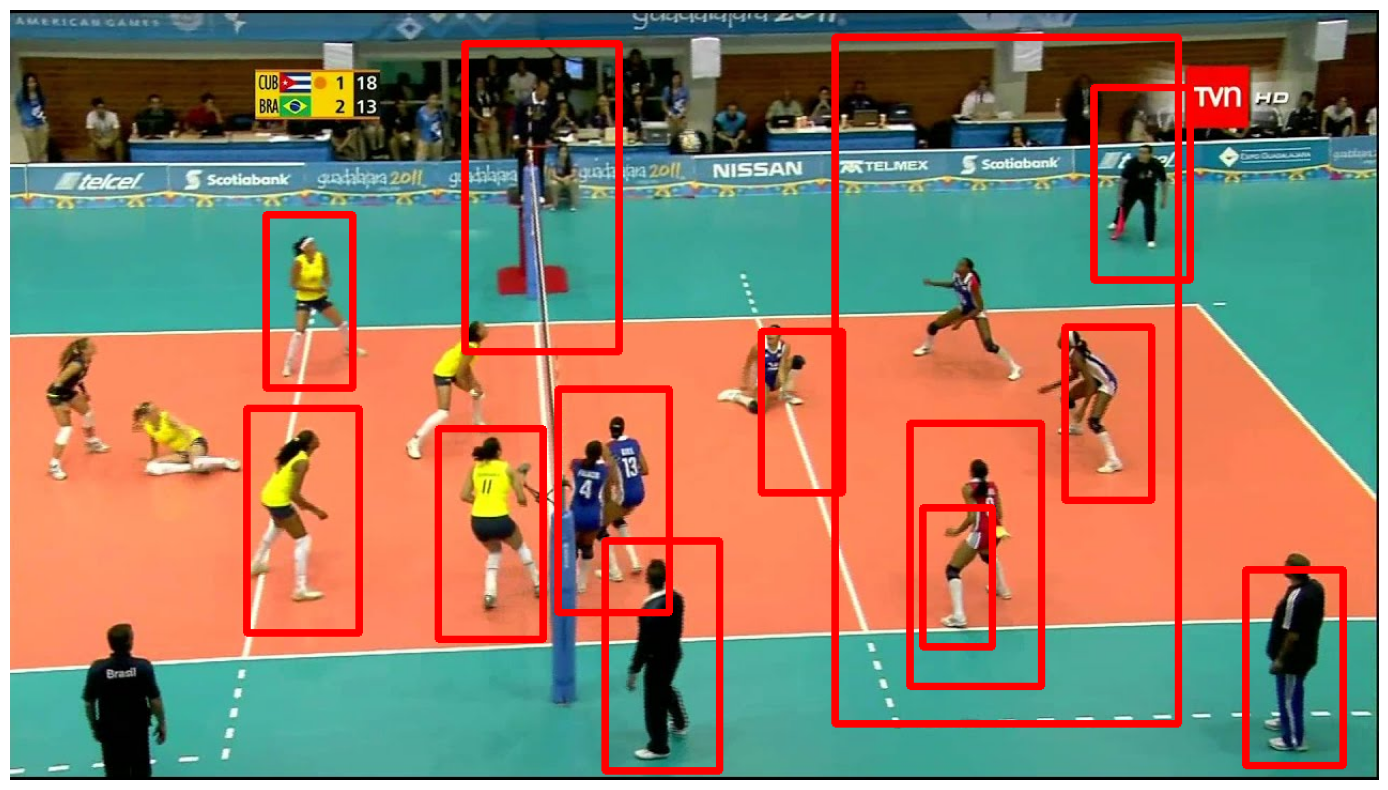

In [1082]:
# Cargar la imagen
I = cv2.imread('images/volei.jpeg')

# Crear un descriptor HOG
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())  # Método corregido

# Detectar peatones
locations, confidence = hog.detectMultiScale(I)

# Dibujar rectángulos alrededor de los peatones detectados
for (x, y, w, h) in locations:
    cv2.rectangle(I, (x, y), (x + w, y + h), (0, 0, 255), 5)

# Convertir la imagen a RGB para mostrarla con Matplotlib
I_rgb = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)

# Mostrar la imagen
plt.figure(figsize=(20, 10))
plt.imshow(I_rgb)
plt.axis('off')
plt.show()


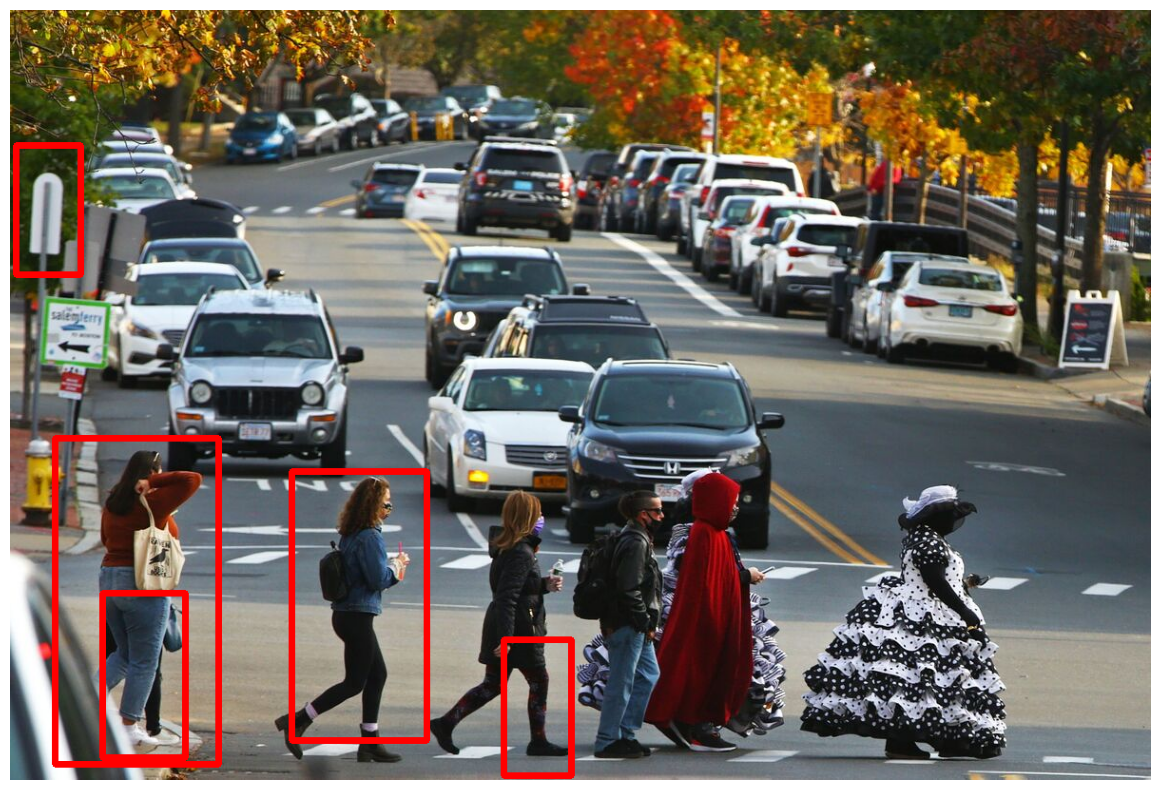

In [1083]:
# Cargar la imagen
I = cv2.imread('images/pedestrians.png')

# Crear un descriptor HOG
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())  # Método corregido

# Detectar peatones
locations, confidence = hog.detectMultiScale(I)

# Dibujar rectángulos alrededor de los peatones detectados
for (x, y, w, h) in locations:
    cv2.rectangle(I, (x, y), (x + w, y + h), (0, 0, 255), 5)

# Convertir la imagen a RGB para mostrarla con Matplotlib
I_rgb = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)

# Mostrar la imagen
plt.figure(figsize=(20, 10))
plt.imshow(I_rgb)
plt.axis('off')
plt.show()


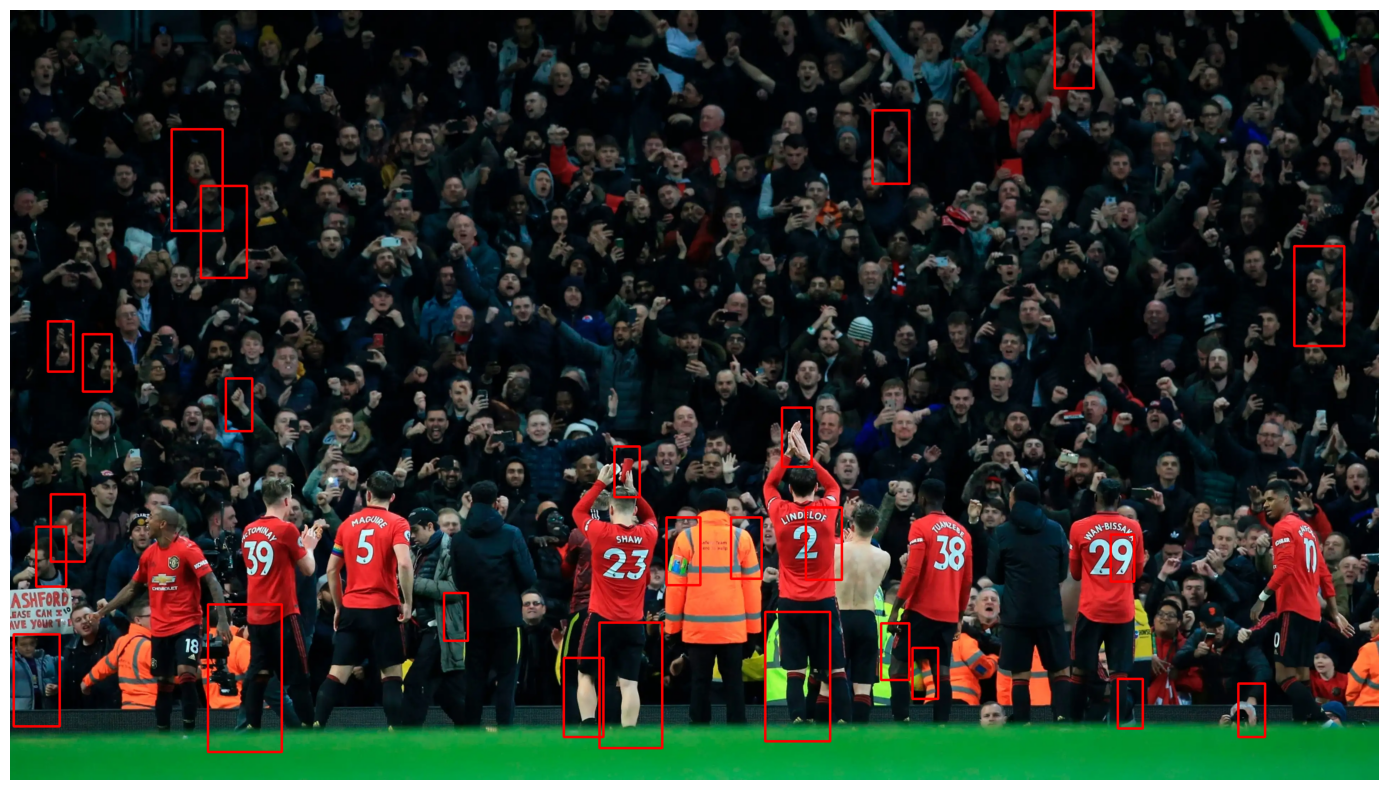

In [1084]:
# Cargar la imagen
I = cv2.imread('images/football.png')

# Crear un descriptor HOG
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())  # Método corregido

# Detectar peatones
locations, confidence = hog.detectMultiScale(I)

# Dibujar rectángulos alrededor de los peatones detectados
for (x, y, w, h) in locations:
    cv2.rectangle(I, (x, y), (x + w, y + h), (0, 0, 255), 5)

# Convertir la imagen a RGB para mostrarla con Matplotlib
I_rgb = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)

# Mostrar la imagen
plt.figure(figsize=(20, 10))
plt.imshow(I_rgb)
plt.axis('off')
plt.show()


El detector en general presenta ciertas ventajas conocidas y varias desventajas puntuales.
### Ventajas:
- Pre-entrenado: Ya ha sido ajustado para detectar personas en diferentes contextos y condiciones de imagen.
- Facilidad de uso: Fácil de usar y no requiere entrenamiento adicional por parte del usuario.
- Rendimiento razonable: Proporciona un rendimiento razonable para la detección de personas en imágenes, lo que lo hace adecuado para aplicaciones básicas de detección de personas.

### Desventajas:
- Generalidad limitada: Aunque el detector por defecto funciona bien en muchas situaciones, puede no ser óptimo para todas las aplicaciones o escenarios específicos. Por ejemplo, puede no funcionar tan bien en imágenes con variaciones extremas de iluminación o con personas en posiciones inusuales.
- No parametrizable: Dado que es un detector pre-entrenado y proporcionado como parte de la biblioteca OpenCV, el detector por defecto no es fácilmente personalizable para adaptarse a necesidades específicas del usuario o a conjuntos de datos específicos para mejorar el rendimiento.
- Rendimiento variable: El rendimiento del detector por defecto puede variar significativamente según el tipo de imágenes y el entorno en el que se utilice. En algunos casos, puede ser necesario ajustar parámetros o utilizar métodos adicionales para mejorar el rendimiento.
- Uso limitado: En ambientes con muchas personas aglomeradas o bien personas parcialmente visibles (como por ejemplo en la piscina) el filtro no logra buen rendimiendo
- Falsos positivos: Tiende a identificar incorrectamente varias partes de una persona o incluso de objetos como si fueran personas